<a href="https://colab.research.google.com/github/david-meltzer/LLMs/blob/main/data_analysis/wiki_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies



In [3]:
%cd drive/MyDrive/LLMs/wikipedia

/content/drive/MyDrive/LLMs/wikipedia


In [ ]:
!pip install datasets
!pip install textstat
!pip install wandb
!pip install -U sentence-transformers

!pip install apache-beam
!pip install transformers[torch] evaluate
!pip install mwparserfromhell

In [35]:
from datasets import load_dataset, load_from_disk
from sentence_transformers import SentenceTransformer
from textstat import flesch_reading_ease as fre
from textstat import flesch_kincaid_grade as fkg
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Definitions

In [69]:
def flesch_scores(example):
    """
    Calculate Flesch Readability scores for each article
    """

    example['fre'] = fre(example['text'])
    example['fkg'] = fkg(example['text'])
    return example

def extract_article_text(example):
    """
    Extracts the text from a Wikipedia article before the "Related pages" and "References" sections.

    Parameters:
        example (dict): Dictionary with key 'text' which contains entire Wikipedia article content as a string.

    Returns:
        str: The article text before the "Related pages" and "References" sections.
    """
    text = example['text']

    # Lower-case all text.
    text = text.lower()

    # Find the positions of the "Related pages" and "References" sections
    related_pages_position = text.find('related pages')
    references_position = text.find('references')

    # Extract the text before the sections
    article_text = ""
    if related_pages_position != -1:
        # If the "Related pages" section is found, extract the text before it
        article_text = text[:related_pages_position]
    elif references_position != -1:
        # If the "References" section is found (but not the "Related pages" section),
        # extract the text before it
        article_text = text[:references_position]
    else:
        # If both sections are not present, return the entire text
        article_text = text

    # Remove leading and trailing whitespace from the extracted text
    article_text = article_text.strip()

    example['text'] = article_text

    return example

def remove_sections(article):

    article_split = article.split('\n')
    article_split = [txt for txt in article_split if len(txt.split())>=5]

    return '\n'.join(article_split)

In [ ]:
#import wandb
#run = wandb.init()
#artifact = run.use_artifact('ft-llmmm/distilgpt2_sw_blm/simplewiki_splits:v2', type='dataset')
#artifact_dir = artifact.download()
#simple_wiki = load_from_disk('./artifacts/simplewiki_splits:v2/simplewiki')

# Code

In [9]:
english_wiki = load_dataset("wikipedia", "20220301.en")
simple_wiki = load_dataset("wikipedia", "20220301.simple")

In [10]:
english_wiki.save_to_disk('./data/english_wiki')

Saving the dataset (0/41 shards):   0%|          | 0/6458670 [00:00<?, ? examples/s]

In [12]:
simple_wiki_title = simple_wiki['train']['title']
shared_titles = set(simple_wiki_title).intersection(set(english_wiki['train']['title']))
diff_titles = set(english_wiki['train']['title']).union(set(simple_wiki_title))
diff_titles = diff_titles - set(english_wiki['train']['title']).intersection(set(simple_wiki_title))
only_in_simple = set(simple_wiki_title)-set(simple_wiki_title).intersection(set(english_wiki['train']['title']))

In [13]:
english_wiki_shared = english_wiki.filter(
    lambda post: post['title'] in shared_titles
)

Filter:   0%|          | 0/6458670 [00:00<?, ? examples/s]

In [15]:
simple_wiki_shared = simple_wiki.filter(
    lambda post: post['title'] in shared_titles
)

Filter:   0%|          | 0/205328 [00:00<?, ? examples/s]

In [70]:
english_wiki_shared['train'] = english_wiki_shared['train'].map(extract_article_text)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [71]:
simple_wiki_shared['train'] = simple_wiki_shared['train'].map(extract_article_text)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [72]:
english_wiki_shared['train'] = english_wiki_shared['train'].map(flesch_scores)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [74]:
simple_wiki_shared['train'] = simple_wiki_shared['train'].map(flesch_scores)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [ ]:
simple_wiki_shared.save_to_disk('./data/simple_wiki_shared')

In [ ]:
english_wiki_shared.save_to_disk('./data/english_wiki_shared')

In [ ]:
plt.hist(simple_wiki_shared['train']['fre'],
         bins=100,
         density=True,
         alpha=.5,
         label='simple')
plt.hist(english_wiki_shared['train']['fre'],
         bins=100,
         density=True,
         alpha=.5,
         label='english')
plt.legend(loc='upper right')
plt.show()

In [53]:
test = english_wiki_shared.filter(lambda post:post['title']=='Anarchism')

Filter:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [54]:
test_2 = simple_wiki_shared.filter(lambda post:post['title']=='Anarchism')

Filter:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [63]:
type(simple_wiki_shared['train'][0]['text'])

str

In [64]:
type(english_wiki_shared['train'][0]['text'])

str

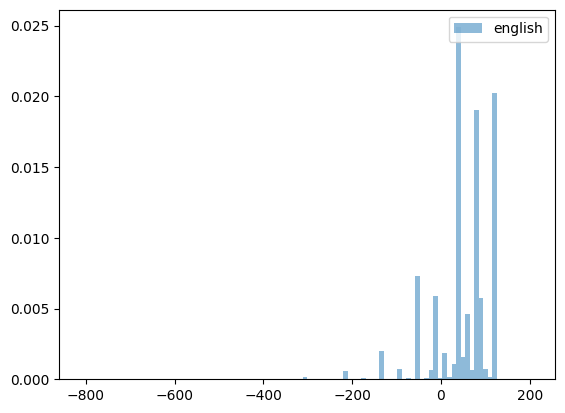

In [51]:

plt.legend(loc='upper right')
plt.show()

# Scratch

In [ ]:
!pip install apache-beam
!pip install -U datasets
!pip install transformers[torch] evaluate
!pip install mwparserfromhell

In [ ]:
from datasets import (load_dataset,
                      load_from_disk,
                      concatenate_datasets)
import torch
from transformers import (AutoModelForCausalLM,
                          TrainingArguments,
                          Trainer,
                          AutoTokenizer,
                          DataCollatorForLanguageModeling)
import random

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
%ls

sample_data/


In [ ]:
%cd drive/MyDrive/LLMs/wikipedia

/content/drive/MyDrive/LLMs/wikipedia


In [ ]:
wiki_simple = load_from_disk('./data/wiki_simple')
wiki_split_tmp = wiki_simple.train_test_split(.1)
validation_dataset = wiki_split_tmp['test']
wiki_split = wiki_split_tmp['train'].train_test_split(test_size=len(wiki_split_tmp['test']))
wiki_split['validation'] = validation_dataset

In [ ]:
samp_train = random.sample(range(len(wiki_split_tmp['train'])),10)

In [ ]:
def trunc_article(text):
    text = text.split('\n')
    new_txt = text[0]
    i=1

    while len(new_txt)<=512 and i<len(text):
        new_txt += ' '+text[i]
        i += 1

    new_txt = ' '.join(new_txt.split())

    return new_txt.strip()

def create_prompt(text):
    prompt= f"Instruction: X\nOutput: {text}\nWhat kind of instruction, X, could this be an answer to?\nX:"
    return prompt

In [ ]:
trunc_articles_samp = list(map(trunc_article,wiki_simple['train'][samp_train]['text']))

In [ ]:
trunc_articles_samp[0]

'Abderrazak Rassaa (\u200e; 4 January 1930 – 7 January 2020) was a Tunisian politician. He was born in Tunis. He was a member of the Socialist Destourian Party. He served as Minister of Finance from 1969 to 1971. He was also Minister of Industry from 1968 to 1969. Rassaa died on 7 January 2020, at the age of 90. References 2020 deaths 1930 births People from Tunis Tunisian politicians'

In [ ]:
prompt = """Instruction {X}\nOutput: {}\nWhat kind of instruction, X, could this be the answer to?\
Write the instruction using Simple English.
X: """

In [ ]:
print(prompt)

Instruction {X}
Output: {}
What kind of instruction, X, could this be the answer to?Write the instruction using Simple English.
X: 
